In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from ucimlrepo import fetch_ucirepo 

**Defining the Parameter Grids**

In [ ]:
# initialize  splits
split_ratios = [0.2, 0.5, 0.8]
results_summary = {}

# random forest parameter grid
Random_grid = {
    'classifier__n_estimators': [100, 200, 300],       
    'classifier__max_depth': [None, 10, 20, 30],      
    'classifier__min_samples_split': [2, 5, 10],      
    'classifier__min_samples_leaf': [1, 2, 4]         
}

#SVM parameter grid

SVM_grid = {
    'classifier__C': [10**i for i in range(-7, 4)]
}

# KNN parameter grid
KNN_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11]
}

#logistic regression grid
logreg_grid = {
    'classifier__C': [10**i for i in range(-4, 4)],
    'classifier__penalty': ['l2'],
    'classifier__max_iter': [500, 1000]
}


#decsion tree
decision_tree_grid = {
    'classifier__criterion': ['gini', 'entropy'],      
    'classifier__max_depth': [3, 5, 10, None],        
    'classifier__min_samples_split': [2, 5, 10],      
}



In [ ]:
def apply_classifier(dataset, classifier_name, param_grid, preprocessor, classifier, X, y):
    model_results = []  
    
    # run model for each split ratio
    for split_ratio in split_ratios:
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=split_ratio, random_state=42, stratify=y)
        
        # pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ])

        # initialize and fit GridSearchCV 
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=3,
            scoring='accuracy',
            verbose=1, # verbose produces an output
            n_jobs=-1  # uses all CPU cores       
        )
        
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)
        
        # store all cv_results as a dictionary to make heat maps later on 
        cv_results_dict = {}
        for key in grid_search.cv_results_.keys():
            if hasattr(grid_search.cv_results_[key], 'tolist'):
                cv_results_dict[key] = grid_search.cv_results_[key].tolist()
            else:
                cv_results_dict[key] = grid_search.cv_results_[key]
        
        # calculate train accuracy and test accuracy 
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        # append to the sckitit learn results to model_results (an instance of results_summary)
        model_results.append({
            'split_ratio': split_ratio,
            'best_params': grid_search.best_params_,
            'best_validation_accuracy': grid_search.best_score_,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'cv_results': cv_results_dict  
        })
    
    # store results globaly in results summary -- key is the data swet and the classifier name 
    results_summary[f"{dataset} {classifier_name}"] = model_results

**Vegas Dataset**

In [4]:
pd.set_option('display.max_columns', None)

# Load data
Vegas = pd.read_csv("C:/Users/leofl/OneDrive/Desktop/COGS118A/Final Project/LasVegasTripAdvisorReviews-Dataset.csv", sep=";")
Vegas


,User country,Nr. reviews,Nr. hotel reviews,Helpful votes,Score,Period of stay,Traveler type,Pool,Gym,Tennis court,Spa,Casino,Free internet,Hotel name,Hotel stars,Nr. rooms,User continent,Member years,Review month,Review weekday
0,USA,11,4,13,5,Dec-Feb,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,9,January,Thursday
1,USA,119,21,75,3,Dec-Feb,Business,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,3,January,Friday
2,USA,36,9,25,5,Mar-May,Families,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,2,February,Saturday
3,UK,14,7,14,4,Mar-May,Friends,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,Europe,6,February,Friday
4,Canada,5,5,2,4,Mar-May,Solo,NO,YES,NO,NO,YES,YES,Circus Circus Hotel & Casino Las Vegas,3,3773,North America,7,March,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,UK,15,4,8,5,Sep-Nov,Couples,YES,YES,NO,YES,YES,YES,The Westin las Vegas Hotel Casino & Spa,4,826,Europe,1,October,Sunday
500,Canada,50,13,29,4,Sep-Nov,Couples,YES,YES,NO,YES,YES,YES,The Westin las Vegas Hotel Casino & Spa,4,826,North America,8,November,Thursday
501,USA,154,23,31,4,Sep-Nov,Friends,YES,YES,NO,YES,YES,YES,The Westin las Vegas Hotel Casino & Spa,4,826,North America,4,November,Thursday
502,USA,9,6,5,2,Dec-Feb,Families,YES,YES,NO,YES,YES,YES,The Westin las Vegas Hotel Casino & Spa,4,826,North America,9,December,Wednesday


In [119]:

numerical_cols = ['Nr. reviews', 'Nr. hotel reviews', 'Helpful votes',
                 'Hotel stars', 'Member years'] 

for col in numerical_cols:
    if Vegas[col].dtype == 'object':
        Vegas[col] = Vegas[col].str.replace(',', '.').astype(float)


Vegas['Target'] = Vegas['Score'].apply(lambda x: 1 if x >= 4 else 0)


categorical_cols = ['Traveler type', 'User country', 'Period of stay', 'Hotel name', 'User continent',
                   'Review month'] 

binary_cols = ['Pool', 'Gym', 'Casino', 'Free internet', 'Tennis court', 'Spa']

Vegas[binary_cols] = Vegas[binary_cols].replace({'NO': 0, 'YES': 1})


print("\nFeature columns being used:")
print("Numerical:", numerical_cols)
print("Categorical:", categorical_cols)
print("Binary:", binary_cols)


Feature columns being used:
Numerical: ['Nr. reviews', 'Nr. hotel reviews', 'Helpful votes', 'Hotel stars', 'Member years']
Categorical: ['Traveler type', 'User country', 'Period of stay', 'Hotel name', 'User continent', 'Review month']
Binary: ['Pool', 'Gym', 'Casino', 'Free internet', 'Tennis court', 'Spa']


In [ ]:
# preprocess the data
# one hot encodes categorical variables 
# normalizes numericaCategoricalng standardscaler 

Vegas = Vegas.dropna()

vegas_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols),
        ('passthrough', 'passthrough', binary_cols) 
    ])

In [ ]:
# prepare X and y
vegas_X = Vegas[categorical_cols + numerical_cols + binary_cols]
vegas_y = Vegas['Target']

In [8]:
apply_classifier('vegas','random_forest', Random_grid, vegas_preprocessor, RandomForestClassifier(), vegas_X, vegas_y)
apply_classifier('vegas','SVM', SVM_grid, vegas_preprocessor,  SVC(kernel='rbf'), vegas_X, vegas_y)
apply_classifier('vegas','KNN', KNN_grid, vegas_preprocessor, KNeighborsClassifier(), vegas_X, vegas_y)
apply_classifier('vegas','log_reg',logreg_grid, vegas_preprocessor, LogisticRegression(), vegas_X, vegas_y)
apply_classifier('vegas','decision_tree', decision_tree_grid, vegas_preprocessor, DecisionTreeClassifier(), vegas_X, vegas_y)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 11 candidates, totalling 33 fits
Fitting 3 folds for each of 11 candidates, totalling 33 fits
Fitting 3 folds for each of 11 candidates, totalling 33 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits


**Taiwan Dataset**

In [9]:
taiwan = pd.read_csv("C:/Users/leofl/OneDrive/Desktop/COGS118A/Final Project/taiwan.csv")
taiwan


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.000000e+00,0.458143,7.250725e-04,0.000000,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,2.559237e-02,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.000000e+00,0.461867,6.470647e-04,0.000000,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9

In [10]:
taiwan_numerical = [
    'ROA(A) before interest and % after tax',
    "ROA(B) before interest and depreciation after tax",
    "Operating Gross Margin",
    "Realized Sales Gross Margin",
    "Operating Profit Rate",
    "Current Ratio",
    "Quick Ratio",
    "Total debt/Total net worth",
    "Debt ratio %",
    "Cash flow rate",
    "Cash Reinvestment %",
    "Realized Sales Gross Profit Growth Rate",
    "Operating Profit Growth Rate",
    "Total Asset Growth Rate",
    "Net Value Growth Rate",
    "Total Asset Turnover",
    "Accounts Receivable Turnover",
    "Inventory Turnover Rate (times)",
    "Cash Flow to Sales",
    "Net Income to Stockholder's Equity"
]

taiwan = taiwan.dropna()
taiwan = taiwan[:500]

taiwan_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), taiwan_numerical)
    ])

In [11]:
# Remove leading and trailing spaces from column names
taiwan.columns = taiwan.columns.str.strip()

taiwan_X = taiwan[taiwan_numerical]
taiwan_y = taiwan['Bankrupt?']

In [12]:
apply_classifier("taiwan", "random_forest", Random_grid, taiwan_preprocessor, RandomForestClassifier(), taiwan_X, taiwan_y)
apply_classifier("taiwan", "SVM", SVM_grid, taiwan_preprocessor, SVC(kernel='rbf'), taiwan_X, taiwan_y)
apply_classifier("taiwan", "KNN", KNN_grid, taiwan_preprocessor, KNeighborsClassifier(weights='uniform', metric='minkowski'), taiwan_X, taiwan_y)
apply_classifier("taiwan", "log_reg", logreg_grid, taiwan_preprocessor, LogisticRegression(), taiwan_X, taiwan_y)
apply_classifier("taiwan", "decision_tree", decision_tree_grid, taiwan_preprocessor, DecisionTreeClassifier(), taiwan_X, taiwan_y)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 11 candidates, totalling 33 fits
Fitting 3 folds for each of 11 candidates, totalling 33 fits
Fitting 3 folds for each of 11 candidates, totalling 33 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits


**Money Dataset**

In [120]:
# fetch dataset 
census_income = fetch_ucirepo(id=20) 
  
# data (as pandas dataframes) 
money_X = census_income.data.features 
money_y = census_income.data.targets 
  

ConnectionError: Error connecting to server

In [16]:
money_y['income'] = money_y['income'].str.replace(r'\.$', '', regex=True)
money_y['income'] = money_y['income'].map({'<=50K': 0, '>50K': 1})

NameError: name 'money_y' is not defined

In [ ]:
unique_values = money_y['income'].unique()
unique_values

array([0, 1], dtype=int64)

In [ ]:
joined = money_X.join(money_y)
joined.dropna()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,33,Private,245211,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,0
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,0
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,0


In [ ]:
money_categorical = ['workclass', 'education','marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
money_numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

money_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), money_numerical),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), money_categorical)
    ])

In [ ]:
Money_X = joined[money_categorical + money_numerical]
Money_X = money_X[:500]
Money_y = joined['income']
Money_y = Money_y[:500]



In [ ]:
apply_classifier("money", "random_forest", Random_grid, money_preprocessor, RandomForestClassifier(), Money_X, Money_y)
apply_classifier("money", "SVM", SVM_grid, money_preprocessor, SVC(kernel='rbf'), Money_X, Money_y)
apply_classifier("money", "KNN", KNN_grid, money_preprocessor, KNeighborsClassifier(weights='uniform', metric='minkowski'), Money_X, Money_y)
apply_classifier("money", "log_reg", logreg_grid, money_preprocessor, LogisticRegression(), Money_X, Money_y)
apply_classifier("money", "decision_tree", decision_tree_grid, money_preprocessor, DecisionTreeClassifier(), Money_X, Money_y)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 11 candidates, totalling 33 fits
Fitting 3 folds for each of 11 candidates, totalling 33 fits
Fitting 3 folds for each of 11 candidates, totalling 33 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits


**Diabetes Dataset**

In [ ]:
# fetch dataset 
early_stage_diabetes_risk_prediction = fetch_ucirepo(id=529) 
  
# data (as pandas dataframes) 
pre_diabetes_X = early_stage_diabetes_risk_prediction.data.features 
pre_diabetes_y = early_stage_diabetes_risk_prediction.data.targets 
  


In [ ]:
diabetes_joined = pre_diabetes_y.join(pre_diabetes_X)
diabetes_joined = diabetes_joined.dropna()

diabetes_joined['class'] = diabetes_joined['class'].map({'Negative': 0, 'Positive': 1})
diabetes_joined['gender'] = diabetes_joined['gender'].map({'Female': 0, 'Male': 1})

In [ ]:
columns_to_convert = diabetes_joined.drop(['class', 'age', 'gender'], axis = 1)
columns_to_convert = columns_to_convert.columns
diabetes_joined[columns_to_convert] = diabetes_joined[columns_to_convert].replace({'No': 0, 'Yes': 1})
diabetes_joined[:500]


,class,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity
0,1,40,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1
1,1,58,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0
2,1,41,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0
3,1,45,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0
4,1,60,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,43,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0
496,0,53,1,0,0,0,1,0,0,1,1,0,1,0,1,1,0
497,0,47,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1
498,1,68,0,1,1,0,1,1,0,1,1,0,1,1,0,0,0


In [ ]:
pass_through_columns = columns_to_convert.to_list()
diabetes_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age']),
        ('passthrough', 'passthrough', pass_through_columns) 
    ])

diabetes_X = diabetes_joined.drop('class', axis = 1)
diabetes_y = diabetes_joined['class']

In [ ]:
apply_classifier('diabetes', 'random_forest', Random_grid, diabetes_preprocessor, RandomForestClassifier(), diabetes_X, diabetes_y)
apply_classifier('diabetes', 'SVM', SVM_grid, diabetes_preprocessor, SVC(kernel = 'rbf'), diabetes_X, diabetes_y)
apply_classifier('diabetes', 'KNN', KNN_grid, diabetes_preprocessor, KNeighborsClassifier(), diabetes_X, diabetes_y)
apply_classifier('diabetes', 'log_reg', logreg_grid, diabetes_preprocessor, LogisticRegression(), diabetes_X, diabetes_y)
apply_classifier('diabetes', 'decision_tree', decision_tree_grid, diabetes_preprocessor, DecisionTreeClassifier(), diabetes_X, diabetes_y)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting 3 folds for each of 11 candidates, totalling 33 fits
Fitting 3 folds for each of 11 candidates, totalling 33 fits
Fitting 3 folds for each of 11 candidates, totalling 33 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits


**Visualizations**

In [ ]:
def create_dataset_plot(data_dict, dataset_name):
    # get the split ratios and the models
    models = ['random_forest', 'SVM', 'KNN', 'log_reg', 'decision_tree']
    split_ratios = [0.2, 0.5, 0.8]  
    
    # use subplots since will be plotting a lot different things in the same graph
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # set positions for bars using np.arange
    y_pos = np.arange(len(models))
    bar_width = 0.25
    
    # colors
    colors = ['#2ecc71', '#3498db', '#9b59b6']
   
    for i, split in enumerate(split_ratios):
        accuracies = []
        for model in models:
            # match key with the data set and teh current model we are using 
            key = f"{dataset_name} {model}"
            
            #match the result with the correct split ratio
            for result in data_dict[key]:
                if result['split_ratio'] == split:
                    accuracies.append(result['test_accuracy'])
                    break
        
        ax.barh(y_pos + i*bar_width, accuracies, bar_width, 
                label=f'Split {split}', alpha=0.8, color=colors[i])
    
    
    ax.set_yticks(y_pos + bar_width)
    ax.set_yticklabels(['Random Forest', 'SVM', 'KNN', 'Logistic Regression', 'Decision Tree'])
    ax.set_xlabel('Test Accuracy')
    ax.set_title(f'{dataset_name.capitalize()} Dataset - Test Accuracy by Model and Split Ratio')
    ax.set_xlim(0.5, 1.0)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return fig

def plot_all_datasets(data_dict):
    datasets = ['vegas', 'taiwan', 'money', 'diabetes']
    
    # this function creates it it for every data set
    figs = []
    for dataset in datasets:
        fig = create_dataset_plot(data_dict, dataset)
        figs.append(fig)
        plt.show()
    
    return figs


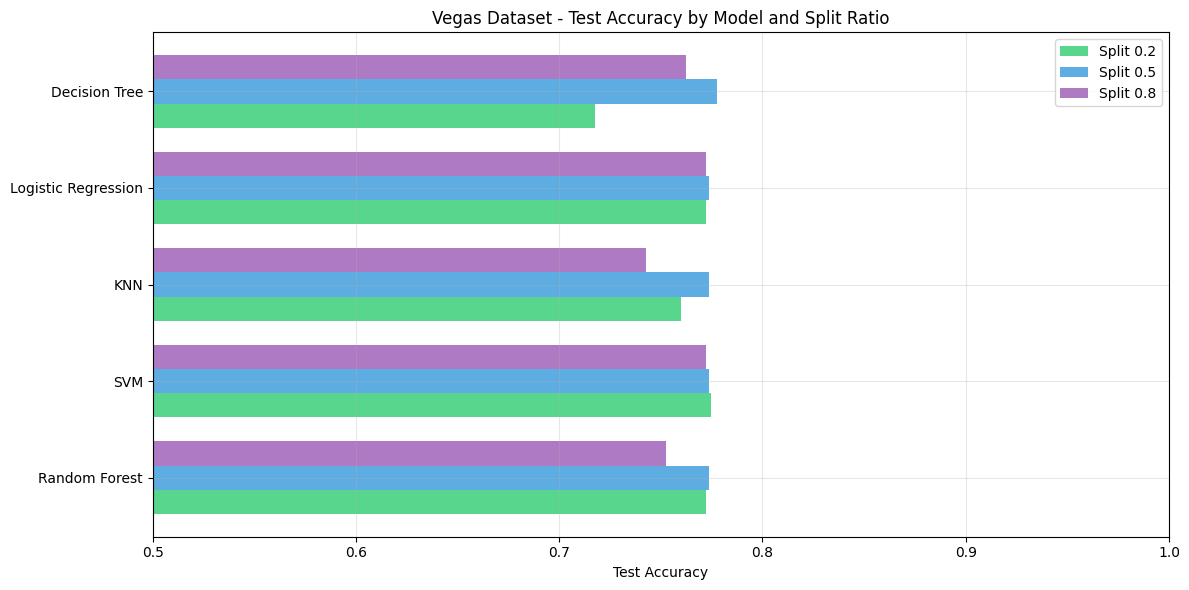

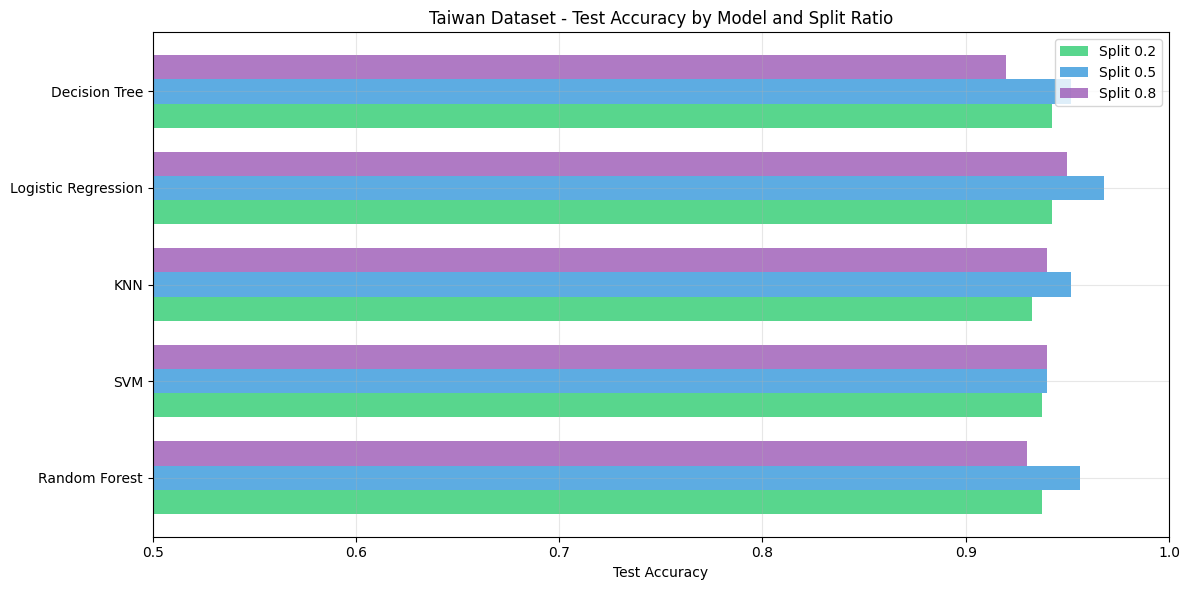

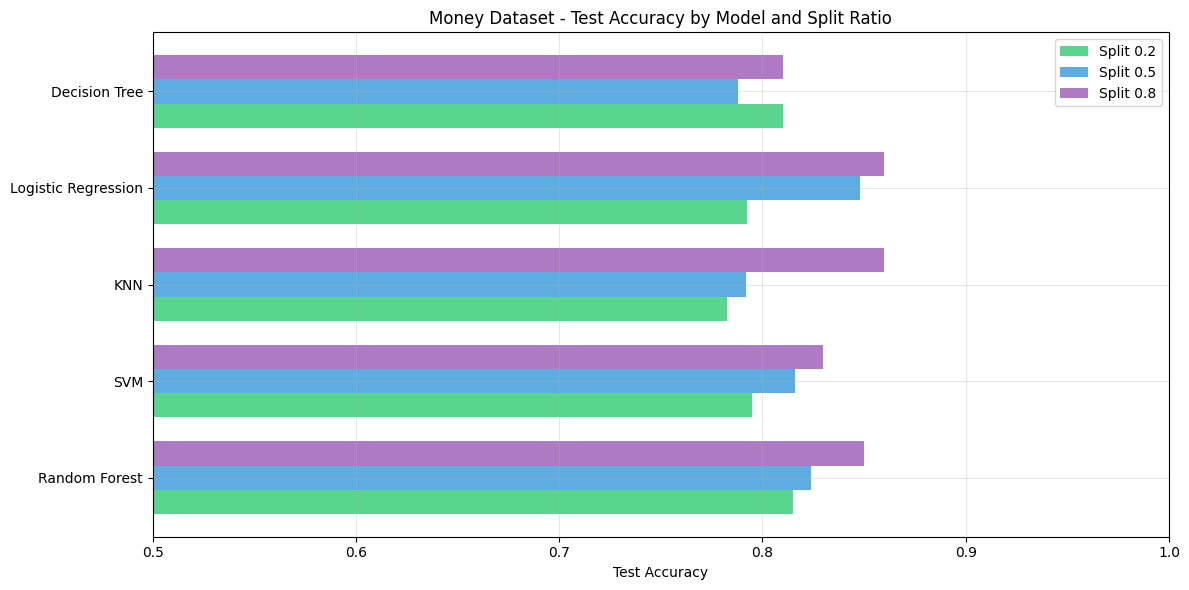

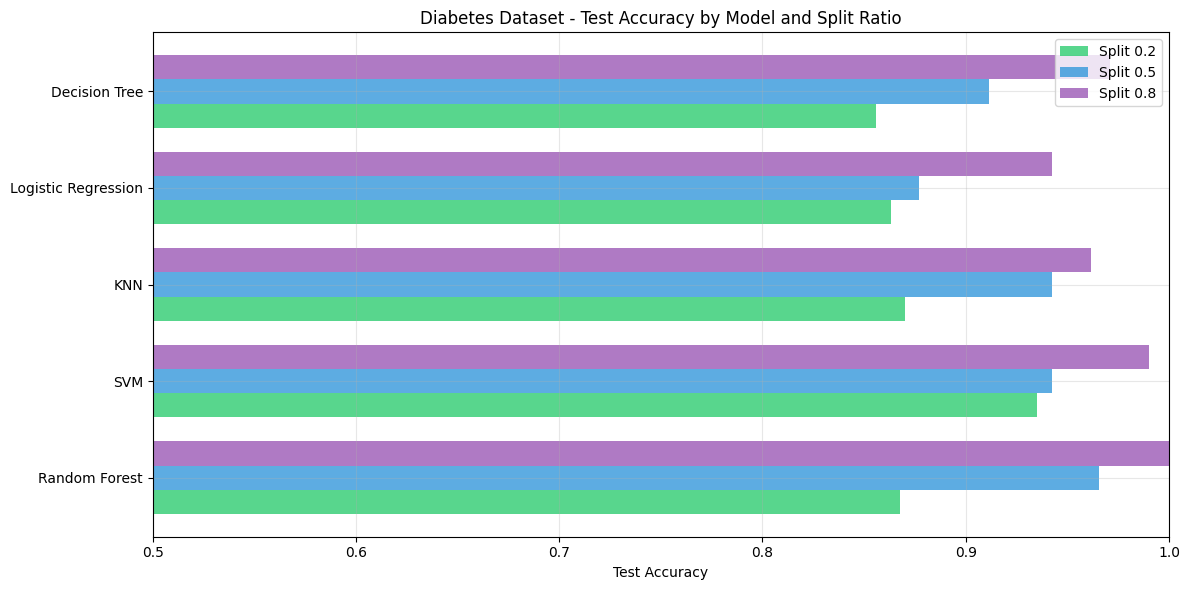

[<Figure size 1200x600 with 1 Axes>,
 <Figure size 1200x600 with 1 Axes>,
 <Figure size 1200x600 with 1 Axes>,
 <Figure size 1200x600 with 1 Axes>]

In [ ]:
plot_all_datasets(results_summary)

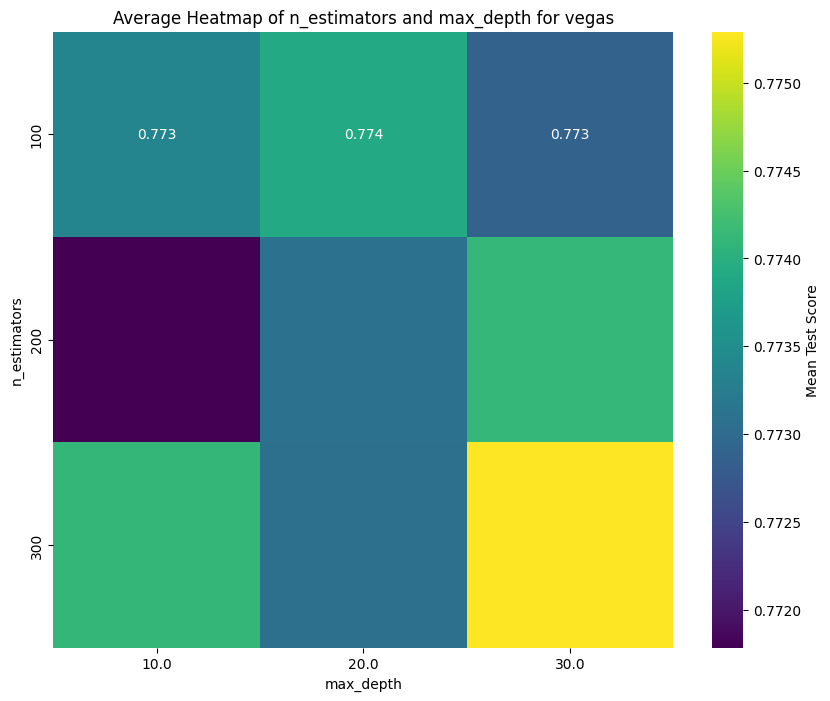

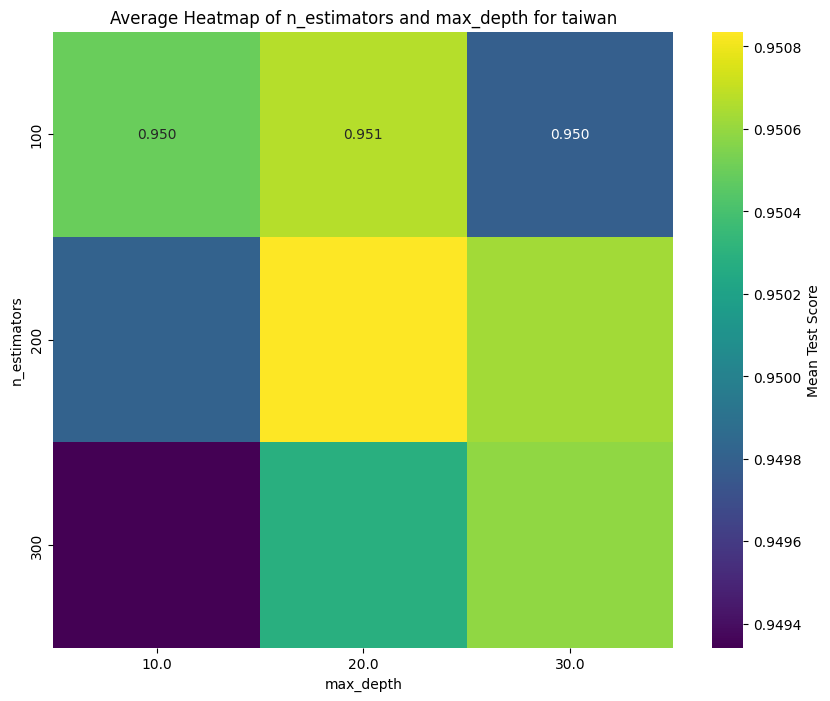

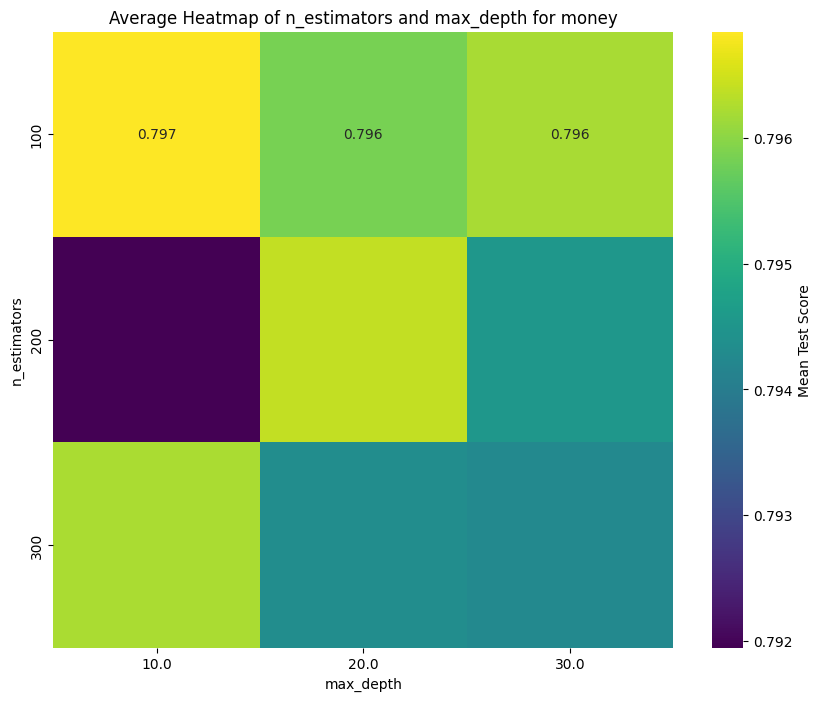

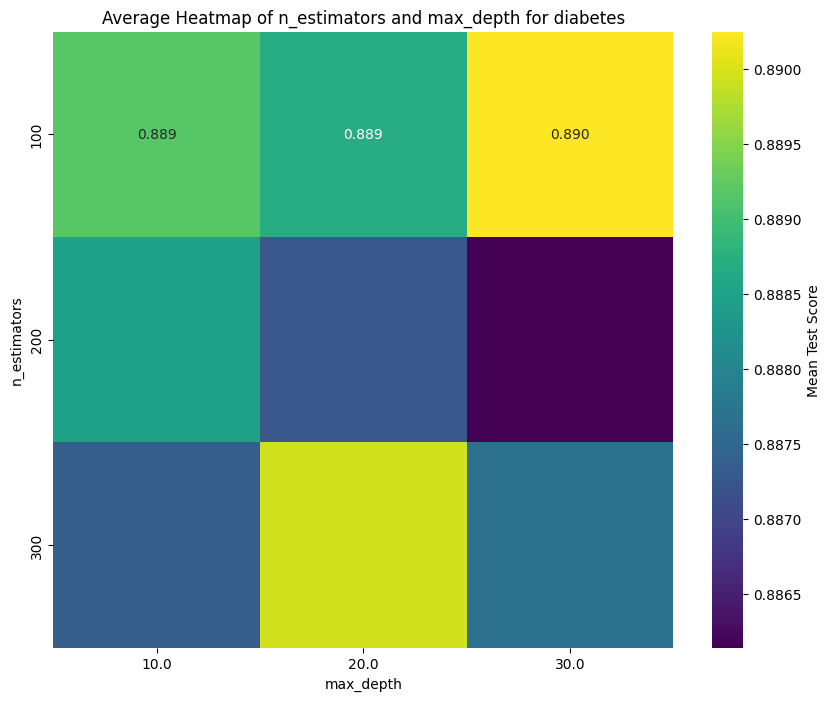

In [ ]:
data_sets = ['vegas', 'taiwan', 'money', 'diabetes']

for dataset in data_sets:
    # initialize a list to collect results for each data set
    dataset_results = []
    
    # get the n_estimators, max_depth and mean test score for each random forest classifier across all data sets
    for j in range(len(results_summary[dataset + ' random_forest'])):
        cv_results = results_summary[dataset + ' random_forest'][j]['cv_results']
        # Collect the parameters and mean test scores
        df = pd.DataFrame({
            'n_estimators': cv_results['param_classifier__n_estimators'],
            'max_depth': cv_results['param_classifier__max_depth'],
            'mean_test_score': cv_results['mean_test_score']
        })
        dataset_results.append(df)
    
    # concatenate the resutls to dataset results
    dataset_results = pd.concat(dataset_results)
    heatmap_data = dataset_results.groupby(['n_estimators', 'max_depth'])['mean_test_score'].mean().unstack()
    
  
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap='viridis', cbar_kws={'label': 'Mean Test Score'})
    plt.title(f'Average Heatmap of n_estimators and max_depth for {dataset}')
    plt.xlabel('max_depth')
    plt.ylabel('n_estimators')
    plt.show()




In [ ]:
results_summary['vegas log_reg'][0]['cv_results']['param_classifier__max_iter']

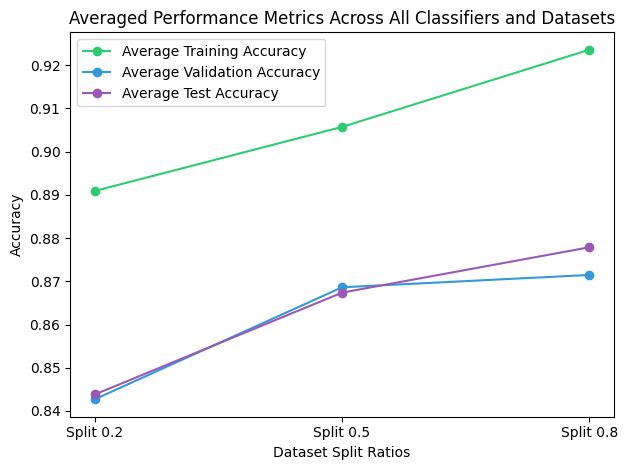

In [ ]:
# Initialize accumulators for averaging across all classifiers and datasets
all_split_ratios = {}

for classifier, results in results_summary.items():
    for result in results:
        split_ratio = result['split_ratio']
        if split_ratio not in all_split_ratios:
            all_split_ratios[split_ratio] = {
                'train_accuracies': [],
                'validation_accuracies': [],
                'test_accuracies': []
            }
        all_split_ratios[split_ratio]['train_accuracies'].append(result['train_accuracy'])
        all_split_ratios[split_ratio]['validation_accuracies'].append(result['best_validation_accuracy'])
        all_split_ratios[split_ratio]['test_accuracies'].append(result['test_accuracy'])

# Compute the averages for each split ratio
split_ratios = sorted(all_split_ratios.keys())
average_train_accuracies = [
    sum(all_split_ratios[ratio]['train_accuracies']) / len(all_split_ratios[ratio]['train_accuracies'])
    for ratio in split_ratios
]
average_validation_accuracies = [
    sum(all_split_ratios[ratio]['validation_accuracies']) / len(all_split_ratios[ratio]['validation_accuracies'])
    for ratio in split_ratios
]
average_test_accuracies = [
    sum(all_split_ratios[ratio]['test_accuracies']) / len(all_split_ratios[ratio]['test_accuracies'])
    for ratio in split_ratios
]

# Create a single averaged line plot
plt.figure(figsize=(10, 6))
plt.plot(split_ratios, average_train_accuracies, marker='o', color = '#2ecc71',  label='Average Training Accuracy')
plt.plot(split_ratios, average_validation_accuracies, marker='o', color = '#3498db', label='Average Validation Accuracy')
plt.plot(split_ratios, average_test_accuracies, marker='o', color = '#9b59b6', label='Average Test Accuracy')

plt.xticks(split_ratios, [f"Split {ratio}" for ratio in split_ratios])
plt.xlabel('Dataset Split Ratios')
plt.ylabel('Accuracy')
plt.title('Averaged Performance Metrics Across All Classifiers and Datasets')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
results_summary

{'vegas random_forest': [{'split_ratio': 0.2,
   'best_params': {'classifier__max_depth': None,
    'classifier__min_samples_leaf': 1,
    'classifier__min_samples_split': 10,
    'classifier__n_estimators': 300},
   'best_validation_accuracy': 0.7902554961378492,
   'train_accuracy': 0.86,
   'test_accuracy': 0.7722772277227723,
   'cv_results': {'mean_fit_time': [0.22405322392781576,
     0.4889212449391683,
     0.782522996266683,
     0.3042000929514567,
     0.5971498489379883,
     0.7883925437927246,
     0.2560574213663737,
     0.5661787986755371,
     0.7186117966969808,
     0.22861901919047037,
     0.5213337739308676,
     0.6870508988698324,
     0.25809383392333984,
     0.40688490867614746,
     0.6349324385325114,
     0.2256192366282145,
     0.3967307408650716,
     0.5843359629313151,
     0.21860726674397787,
     0.37280774116516113,
     0.5845090548197428,
     0.2126945654551188,
     0.3978671232859294,
     0.5941394170125326,
     0.21021596590677896,
     0

In [ ]:
def create_accuracy_summary_df(results):

    data = []
    
    for key, value in results.items():
        dataset, classifier = key.split(' ', 1)
        
        # have to basically remove cv_results because unescessary in the df
        for split_info in value:
            data.append({
                'Dataset': dataset,
                'Classifier': classifier,
                'Split Ratio': split_info['split_ratio'],
                'Validation Accuracy': split_info['best_validation_accuracy'],
                'Train Accuracy': split_info['train_accuracy'],
                'Test Accuracy': split_info['test_accuracy']
            })
   
    df = pd.DataFrame(data)
    
    df = df.sort_values(['Dataset', 'Classifier', 'Split Ratio'])
    
    # round for readability 
    accuracy_columns = ['Validation Accuracy', 'Train Accuracy', 'Test Accuracy']
    df[accuracy_columns] = df[accuracy_columns].round(4)
    
    return df

# Create df
df = create_accuracy_summary_df(results_summary)

# Get mean accuracies by dataset and classifier
mean_accuracies = df.groupby(['Dataset', 'Classifier'])[
    ['Validation Accuracy', 'Train Accuracy', 'Test Accuracy']
].mean()

In [127]:
mean_accuracies

Validation Accuracy  Train Accuracy  Test Accuracy
Dataset  Classifier                                                       
diabetes KNN                       0.887800        0.960767       0.924667
         SVM                       0.905933        0.975467       0.955933
         decision_tree             0.904300        0.955600       0.912833
         log_reg                   0.862100        0.883333       0.894067
         random_forest             0.922833        0.955467       0.944400
money    KNN                       0.809000        0.848333       0.811500
         SVM                       0.812233        0.883667       0.813667
         decision_tree             0.797600        0.881333       0.802667
         log_reg                   0.817067        0.851667       0.833500
         random_forest             0.820400        0.957000       0.829667
taiwan   KNN                       0.957467        0.963833       0.941500
         SVM                       0.947033        0.972833       0.939167
         decision_tree             0.965033        0.999167       0.938167
         log_reg                   0.958367        0.968167       0.953500
         random_forest             0.962567        0.998667       0.941167
vegas    KNN                       0.785767        0.795900       0.758767
         SVM                       0.779067        0.779000       0.773633
         decision_tree             0.758400        0.815367       0.752667
         log_reg                   0.781600        0.778167       0.772800
         random_forest             0.784233        0.911000       0.766200